In [1]:
# JUST FOR TESTING PURPOSES, DATASET CREATION IN run_gnn_model

In [2]:
import sys
#print(sys.path)
# sys.path.insert(0, '/eos/user/c/czeh/.local/lib/python3.9/site-packages')

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

input_folder = "/eos/user/c/czeh/histo"
output_folder = "/eos/user/c/czeh/graph_data"

The scikit-learn version is 1.5.1.
Python version
3.11.9 (main, Jun 24 2024, 14:32:54) [GCC 11.3.0]
Version info.
sys.version_info(major=3, minor=11, micro=9, releaselevel='final', serial=0)


In [3]:
import os
from glob import glob
from tqdm import tqdm
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch_geometric.data import Data
import torch_geometric
import networkx as nx

import awkward as ak
import numpy as np

print('The numpy version is {}.'.format(np.__version__))

import uproot as uproot
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
import scipy.spatial.distance

from ClusterDataset import ClusterDataset
from torch_geometric.loader.dataloader import DataLoader

%matplotlib inline

The numpy version is 1.26.4.


## Load Data

In [4]:
# use this to load the tree if some of file.keys() are duplicates ending with different numbers
def load_branch_with_highest_cycle(file, branch_name):

    # Get all keys in the file
    all_keys = file.keys()

    # Filter keys that match the specified branch name
    matching_keys = [key for key in all_keys if key.startswith(branch_name)]

    if not matching_keys:
        raise ValueError(f"No branch with name '{branch_name}' found in the file.")

    # Find the key with the highest cycle
    highest_cycle_key = max(matching_keys, key=lambda key: int(key.split(";")[1]))

    # Load the branch with the highest cycle
    branch = file[highest_cycle_key]

    return branch

In [5]:
# input_folder = "/eos/user/a/aperego/SampleProduction/TICLv5/ParticleGunPion/histo"
files = glob(f"{input_folder}/train/*.root")
print(files[0])
file = uproot.open(files[0])
print(file.keys())

alltracksters = load_branch_with_highest_cycle(file,'ticlDumper/ticlTrackstersCLUE3DHigh')
allclusters = load_branch_with_highest_cycle(file,'ticlDumper/clusters')
allsimtrackstersCP = load_branch_with_highest_cycle(file, 'ticlDumper/simtrackstersCP')
allassociations = load_branch_with_highest_cycle(file, 'ticlDumper/associations')
allgraph = load_branch_with_highest_cycle(file, 'ticlDumper/TICLGraph')
print(alltracksters.show())

/eos/user/c/czeh/histo/train/histo_double_pion.root
['ticlDumper;1', 'ticlDumper/ticlTrackstersCLUE3DHigh;1', 'ticlDumper/ticlTracksterLinks;1', 'ticlDumper/ticlCandidate;1', 'ticlDumper/ticlTracksterLinksSuperclusteringDNN;1', 'ticlDumper/simtrackstersSC;1', 'ticlDumper/simtrackstersCP;1', 'ticlDumper/clusters;1', 'ticlDumper/candidates;1', 'ticlDumper/TICLGraph;1', 'ticlDumper/superclustering;1', 'ticlDumper/associations;1', 'ticlDumper/tracks;1', 'ticlDumper/simTICLCandidate;1']
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event                | edm::EventID             | AsGroup(<TBranchElement 'ev...
event/run_           | uint32_t                 | AsDtype('>u4')
event/luminosityB... | uint32_t                 | AsDtype('>u4')
event/event_         | uint64_t                 | AsDtype('>u8')
NTracksters          | uint32_t                 | AsDtype('>u4')
NClusters 

In [6]:
node_feature_keys_before = ["barycenter_x", "barycenter_y", "barycenter_z", "barycenter_eta", "barycenter_phi", "eVector0_x", "eVector0_y", "eVector0_z",  "EV1", "EV2", "EV3", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "raw_energy", "raw_em_energy", "time"]
data = alltracksters.arrays(node_feature_keys_before)
data

<Array [{barycenter_x: [...], ...}, ..., {...}] type='100 * {barycenter_x: ...'>

## Prepare Feature Data

In [7]:
alltracksters_array = alltracksters.arrays()
allassociations_array = allassociations.arrays()
cluster_number_of_hits = allclusters.arrays().cluster_number_of_hits
cluster_layer_id = allclusters.arrays().cluster_layer_id
vertices_indexes = alltracksters.arrays().vertices_indexes
NTracksters = alltracksters.arrays().NTracksters
allgraph_array = allgraph.arrays()

In [8]:
data["vertices"] = ak.concatenate([alltracksters_array["vertices_x"][:, :, :, np.newaxis], alltracksters_array["vertices_y"][:, :, :, np.newaxis], alltracksters_array["vertices_z"][:, :, :, np.newaxis]], axis=-1)

In [9]:
data["vertices"][0]

<Array [[[56.1, 31.3, 357], ..., [...]], ...] type='20 * var * 3 * float32'>

In [10]:
num_LCs = ak.count(alltracksters.arrays().vertices_indexes, axis=2)
data["num_LCs"] = num_LCs

In [11]:
data["z_min"] = ak.min(alltracksters.arrays().vertices_z, axis=2)
data["z_max"] = ak.max(alltracksters.arrays().vertices_z, axis=2)


In [12]:
volume = 2*(3 - 1.5) * (2 * 47)
data["trackster_density"] = ak.Array(np.zeros_like(data.num_LCs)) + NTracksters / volume
data["LC_density"] = data.num_LCs / volume

In [13]:
hits = ak.to_list(np.zeros_like(data.num_LCs))
length = ak.to_list(np.zeros_like(data.num_LCs))

cluster_hits = cluster_number_of_hits[ak.flatten(vertices_indexes, axis=-1)]
cluster_layer_ids = cluster_layer_id[ak.flatten(vertices_indexes, axis=-1)]
vertices_count = ak.count(vertices_indexes, axis=-1)

for i in range(len(alltracksters.arrays())):
    hits[i] = ak.sum(ak.unflatten(cluster_hits[i], vertices_count[i]), axis=-1)
    length[i] = (ak.max(ak.unflatten(cluster_layer_ids[i], vertices_count[i]), axis=-1) - ak.min(ak.unflatten(cluster_layer_ids[i], vertices_count[i]), axis=-1)) / 47
        
data["num_hits"] = hits
data["length"] = length

In [14]:
data["photon_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 0]
data["electron_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 1]
data["muon_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 2]
data["neutral_pion_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 3]
data["charged_hadron_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 4]
data["neutral_hadron_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 5]

In [15]:
idx = allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP_score<0.2
simTracksters = allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP[allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP_score<0.2]
emptys = np.full_like(ak.count(allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP, axis=-1), -1) 

data["y"] = ak.flatten(ak.where(ak.count(simTracksters, axis=-1)==1, allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP[idx], ak.unflatten(emptys, 1, axis=-1)), axis=-1)
data["shared_e"] = ak.flatten(ak.where(ak.count(simTracksters, axis=-1)==1, allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP_sharedE[idx], ak.unflatten(emptys, 1, axis=-1)), axis=-1)
data["score"] = ak.flatten(ak.where(ak.count(simTracksters, axis=-1)==1, allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP_score[idx], ak.unflatten(emptys, 1, axis=-1)), axis=-1)

In [16]:
data["y"]

<Array [[1, 1, 1, 1, 1, 0, ..., 0, 0, 0, 0, 0], ...] type='100 * var * int64'>

In [17]:
node_feature_keys = ["barycenter_x", "barycenter_y", "barycenter_z", "barycenter_eta", "barycenter_phi", "eVector0_x", "eVector0_y", "eVector0_z",  "EV1", "EV2", "EV3", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "num_LCs", "num_hits", "raw_energy", "raw_em_energy", "photon_prob", "electron_prob", "muon_prob", "neutral_pion_prob", "charged_hadron_prob", "neutral_hadron_prob", "z_min", "z_max", "length", "LC_density", "trackster_density", "time"]

In [18]:
node_feature_keys_plot = ["barycenter_x", "barycenter_y", "barycenter_z", "y", "score", "shared_e", "barycenter_eta", "barycenter_phi", "eVector0_x", "eVector0_y", "eVector0_z",  "EV1", "EV2", "EV3", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "num_LCs", "num_hits", "raw_energy", "raw_em_energy", "photon_prob", "electron_prob", "muon_prob", "neutral_pion_prob", "charged_hadron_prob", "neutral_hadron_prob", "z_min", "z_max", "length", "LC_density", "trackster_density", "time"]
node_feature_names_plot = ["x", "y", "z", "sim_trackster", "sim_trackster_score", "sim_trackster_shared_energy", "eta", "phi", "eig_x", "eig_y", "eig_z",  "EV1", "EV2", "EV3", "sigmaPCA_x", "sigmaPCA_y", "sigmaPCA_z", "num_LC", "num_hits", "raw_energy", "raw_em_energy", "photon_prob", "electron_prob", "muon_prob", "neutral_pion_prob", "charged_hadron_prob", "neutral_hadron_prob", "z_min", "z_max", "length", "LC_density", "trackster_density", "time"]

100%|██████████| 33/33 [00:03<00:00,  8.79it/s]
/tmp/ipykernel_3902/2186559242.py:18: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


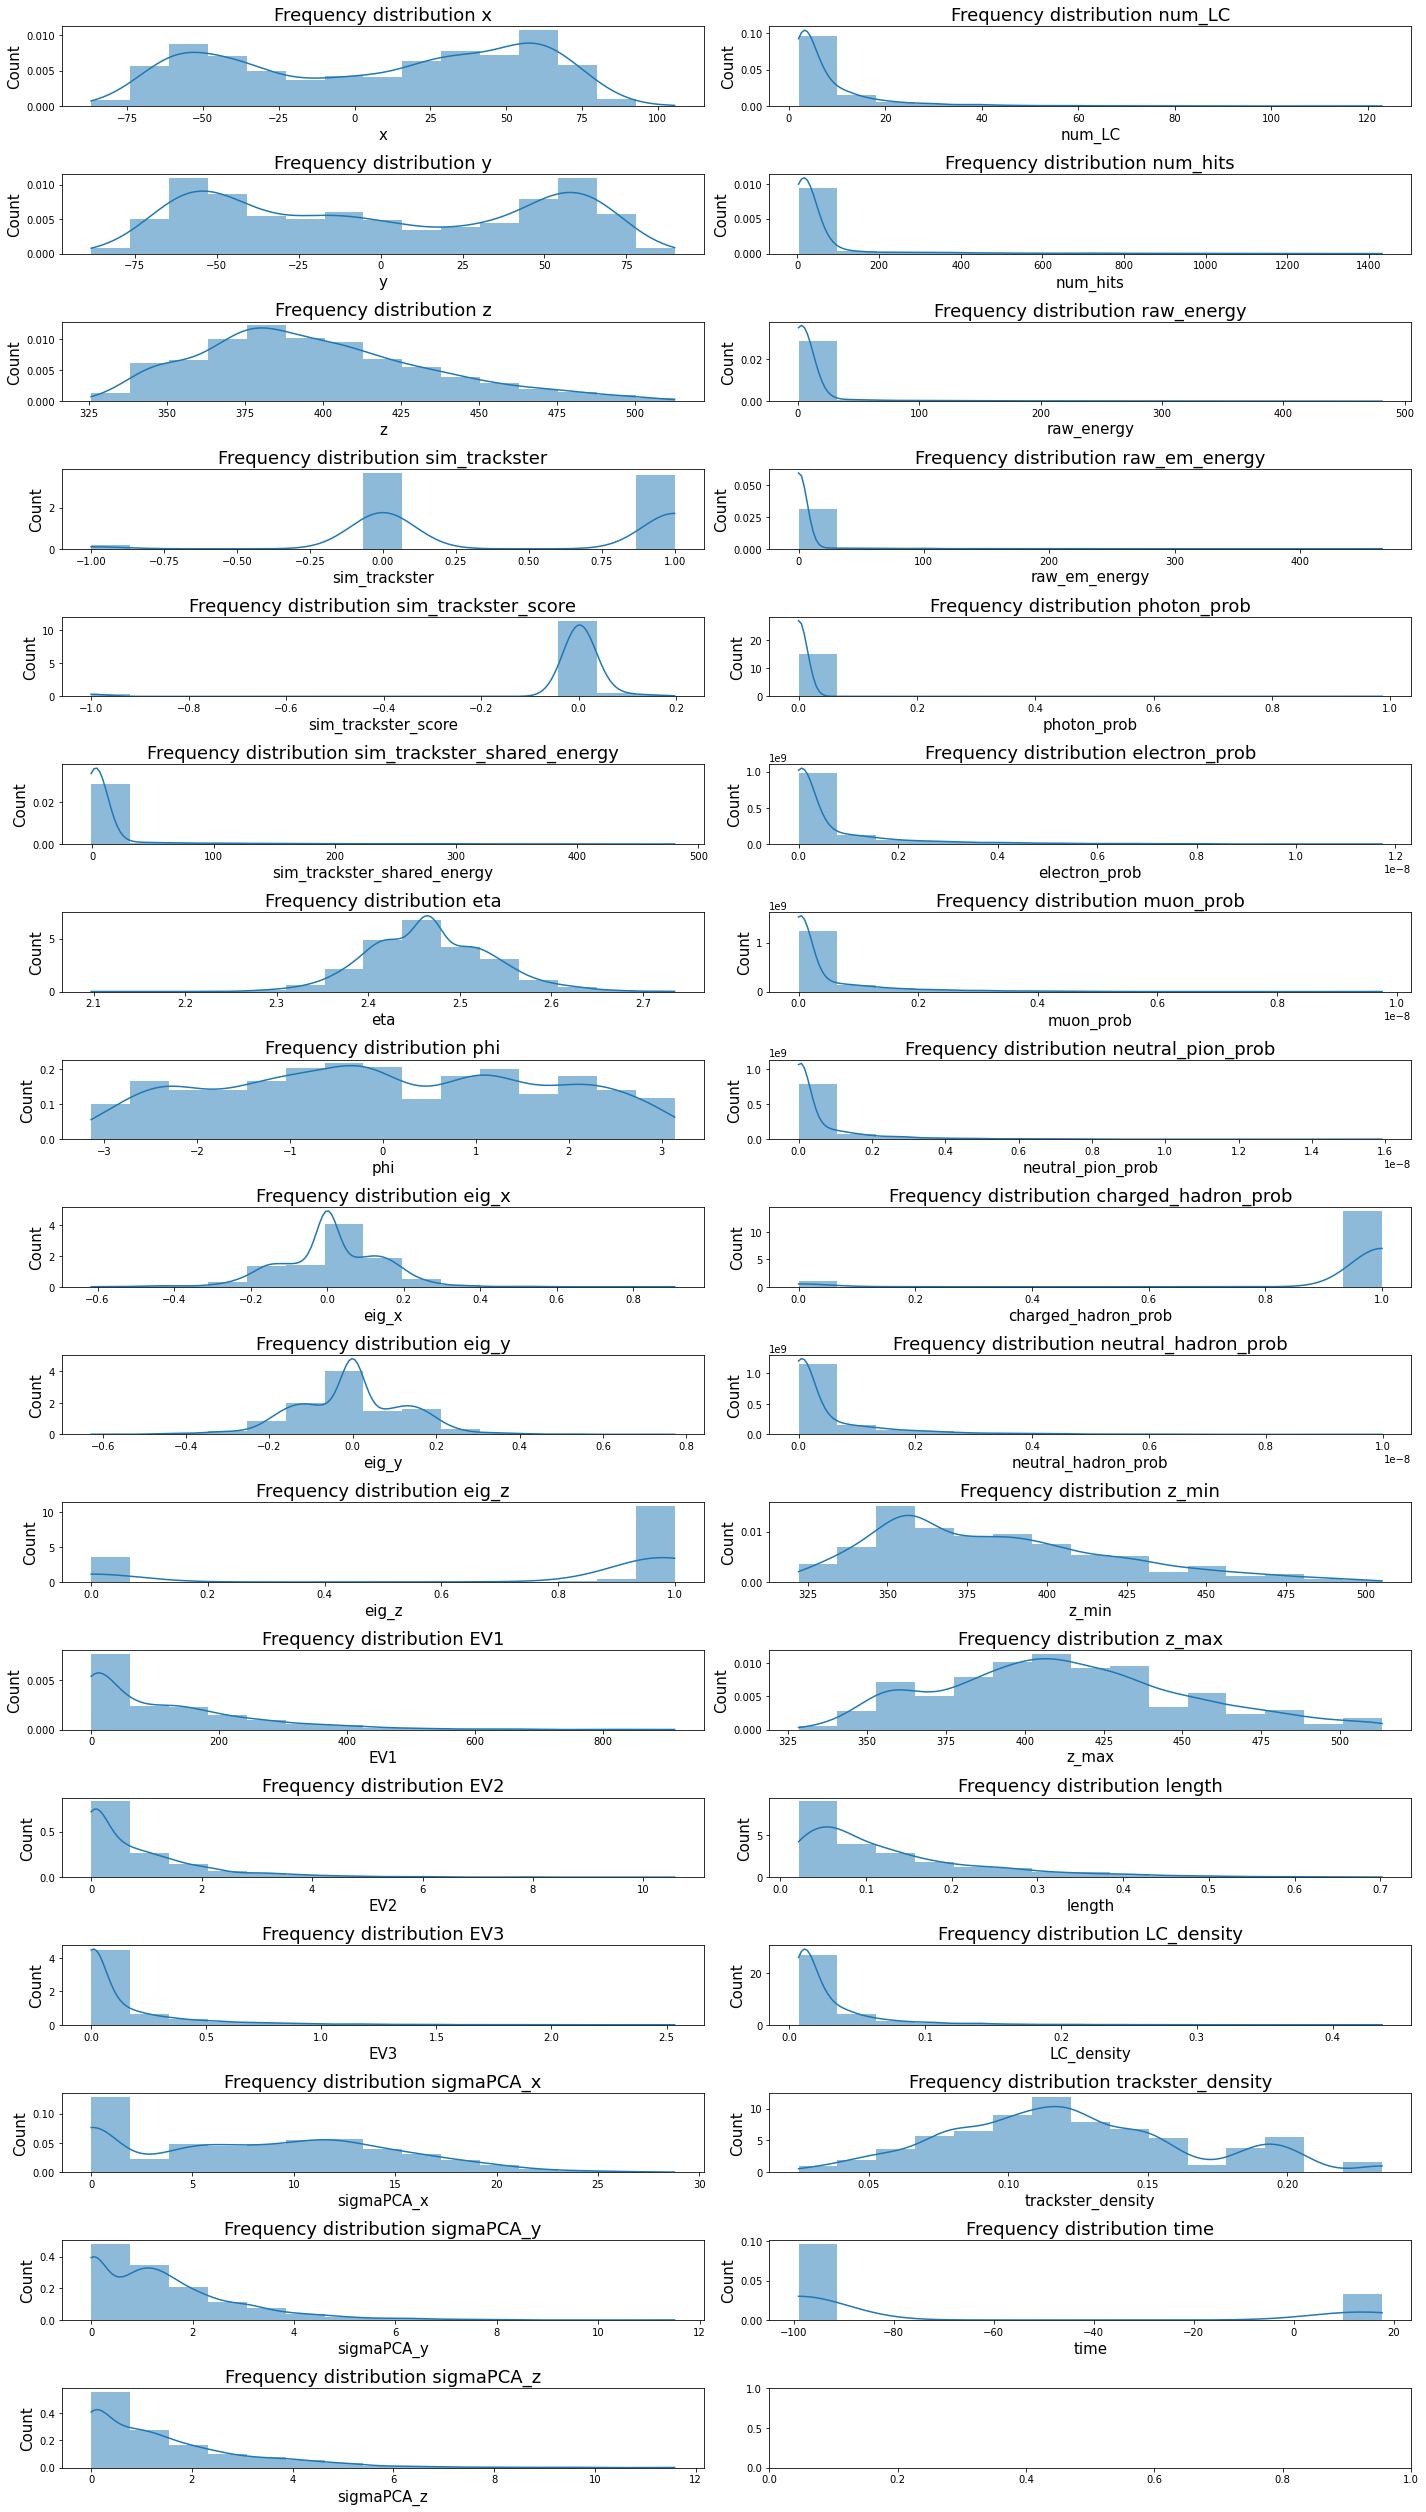

In [19]:
track_vals = []

scols = int(np.ceil(len(node_feature_keys_plot)/2))
srows = 2
fig, axes = plt.subplots(scols, srows, figsize=(20, 35), constrained_layout=True)

for i in tqdm(range(len(node_feature_keys_plot))):
    ax_col = int(i%scols)
    ax_row = int(i/scols)
    
    values = ak.flatten(data[node_feature_keys_plot[i]])
    track_vals.append(values)
    sns.histplot(values, ax=axes[ax_col, ax_row], kde=True, stat="density", linewidth=0, bins=15)
    axes[ax_col, ax_row].set_title('Frequency distribution '+ node_feature_names_plot[i], fontsize=18)
    axes[ax_col, ax_row].set_xlabel(node_feature_names_plot[i], fontsize=15)
    axes[ax_col, ax_row].set_ylabel('Count', fontsize=15)
    
fig.tight_layout()
plt.show()

In [20]:
track_vals = np.array(track_vals)

In [21]:
corr_matrix = np.corrcoef(track_vals)
print(corr_matrix.shape)

(33, 33)


Text(0.5, 1.0, 'Correlation Matrix of the Trackster Features')

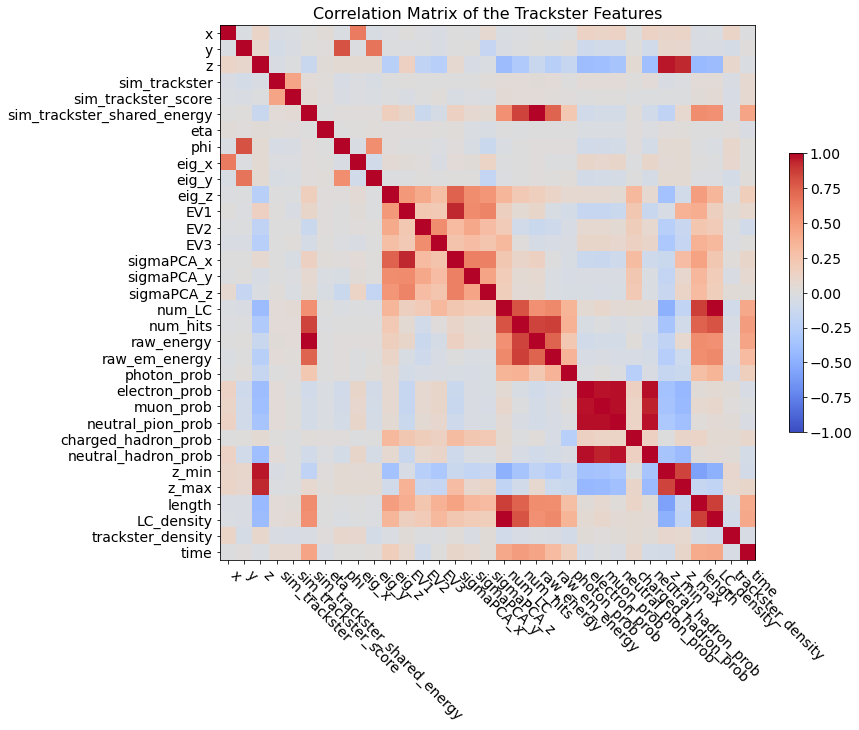

In [22]:
f = plt.figure(figsize=(12, 10))
plt.matshow(corr_matrix, fignum=f.number, cmap='coolwarm', vmin=-1, vmax=1)

plt.xticks(range(len(node_feature_names_plot)), node_feature_names_plot, fontsize=14, rotation=-45, ha="left")
plt.yticks(range(len(node_feature_names_plot)), node_feature_names_plot, fontsize=14)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix of the Trackster Features', fontsize=16)

## Check no PileUp

Text(0.5, 0, 'z (cm)')

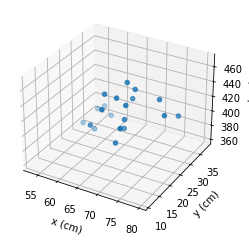

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data[0].barycenter_x, data[0].barycenter_y, data[0].barycenter_z)

ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_zlabel('z (cm)')

## Create Graph Data

In [24]:
roots = ak.num(allgraph_array.inner, axis=-1)
data["roots"] = ak.local_index(roots)[roots  == 0]

In [25]:
data["idx"] = ak.local_index(data.barycenter_x)

In [26]:
graph_list = []
for event in range(10):    
    nodes = np.zeros((NTracksters[event], len(node_feature_keys)))
    for i, key in enumerate(node_feature_keys):
        nodes[:, i] = ak.to_numpy(data[event][key])

    # Create base graph from geometrical graph    
    edges = [[], []]
    for i in range(NTracksters[event]):
        edges[0].extend([i] * len(allgraph_array[event].outer[i]))    
        edges[1].extend(allgraph_array[event].outer[i])
        
    edges = np.array(edges)
    
    edge_features = np.zeros((len(edges[0, :]), 7))
    edge_features[:, 4] = np.linalg.norm(nodes[edges[1, :], :2] - nodes[edges[0, :], :2], axis=1)
    
    edge_features[:, 0] = np.abs(nodes[edges[1, :], 16] - nodes[edges[0, :], 16])
    edge_features[:, 1] = np.abs(nodes[edges[1, :], 2] - nodes[edges[0, :], 2])
    edge_features[:, 5] = np.arccos(np.clip(np.sum(np.multiply(nodes[edges[1, :], 5:8], nodes[edges[0, :], 5:8]), axis=1), a_min=-1, a_max=1))
    edge_features[:, 6] = np.abs(nodes[edges[1, :], 28] - nodes[edges[0], 28])
    
    # y
    y = np.zeros(edges.shape[1])
    for i, e in enumerate(edges.T):
        if((data[event].y[e[0]] != -1) and (data[event].y[e[0]] == data[event].y[e[1]])):
            y[i] = (1-data[event].score[e[0]]) * data[event].shared_e[e[0]]/data[event].raw_energy[e[0]] + (1-data[event].score[e[1]]) * data[event].shared_e[e[1]]/data[event].raw_energy[e[1]]
            
    graph_list.append(Data(x=torch.from_numpy(nodes), num_nodes=NTracksters[event],
                        edge_index=torch.from_numpy(edges), edges_features=edge_features, y=torch.from_numpy(y),
                          y_trans = data["y"][event]))

In [27]:
graph_list

[Data(x=[20, 30], edge_index=[2, 74], y=[74], num_nodes=20, edges_features=[74, 7], y_trans=[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 Data(x=[14, 30], edge_index=[2, 33], y=[33], num_nodes=14, edges_features=[33, 7], y_trans=[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1]),
 Data(x=[29, 30], edge_index=[2, 226], y=[226], num_nodes=29, edges_features=[226, 7], y_trans=[0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 Data(x=[11, 30], edge_index=[2, 29], y=[29], num_nodes=11, edges_features=[29, 7], y_trans=[0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]),
 Data(x=[23, 30], edge_index=[2, 137], y=[137], num_nodes=23, edges_features=[137, 7], y_trans=[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 Data(x=[22, 30], edge_index=[2, 90], y=[90], num_nodes=22, edges_features=[90, 7], y_trans=[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]),
 Data(x=[31, 30], edge_index=[2, 164], y=[164], num_nodes=31, edges_featur

In [28]:
graph_list[5].y

tensor([1.9997, 1.9997, 1.9976, 1.9997, 1.9979, 1.9997, 1.9743, 1.9997, 2.0000,
        1.9980, 2.0000, 1.9982, 2.0000, 2.0000, 1.9746, 1.9980, 1.9980, 1.9962,
        1.9980, 1.9725, 2.0000, 2.0000, 1.9982, 0.0000, 1.9746, 2.0000, 1.9982,
        0.0000, 0.0000, 0.0000, 1.9746, 1.9746, 1.9728, 1.9746, 2.0000, 2.0000,
        1.9982, 1.9982, 2.0000, 2.0000, 2.0000, 1.9926, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 1.9926, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 1.9926, 2.0000, 2.0000, 2.0000, 2.0000, 1.9926,
        1.9926, 1.9926, 1.9926, 1.9926, 1.9926, 1.9926, 2.0000, 2.0000, 2.0000,
        1.9926, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000],
       dtype=torch.float64)

## Prepare Slow Edge Data
Not in Graph Data, as way to slow just for tests

In [29]:
transp = edges.T
edge_indices = np.zeros((NTracksters[event], NTracksters[event], ), dtype=np.int64)

for i in range(len(edges[0, :])):
    edge_indices[transp[i, 0], transp[i, 1]] = i

In [30]:
for root in range(edge_indices.shape[0]):
    tree = KDTree(data["vertices"][0, root], leaf_size=2)
    num = len(data["vertices"][0, root])
    for target in range(edge_indices.shape[1]):
        if (edge_indices[root, target] == -1):
            continue
        if (root != target):
            dist, _ = tree.query(data["vertices"][0, target], k=num)
            edge_features[edge_indices[root, target], 2] = np.min(dist)
            edge_features[edge_indices[root, target], 3] = np.max(dist)

            edge_features[edge_indices[target, root], 2] = np.min(dist)
            edge_features[edge_indices[target, root], 3] = np.max(dist)
        else:
            edge_features[edge_indices[root, target], 2] = 0
            edge_features[edge_indices[root, target], 3] = 0

In [31]:
print(np.mean(edge_features[:, 4]))
print(np.median(edge_features[:, 4]))
print(np.min(edge_features[:, 4]))
print(np.max(edge_features[:, 4]))

9.070034246338173
7.046191948932998
1.3955297192456775
22.923192766873093


## Analyse Dataset

In [32]:
# Load the dataset
hist_folder = "/eos/user/c/czeh/histo/"
data_folder_training = "/eos/user/c/czeh/graph_data"
data_folder_test = "/eos/user/c/czeh/graph_data_test"

model_folder = "/eos/user/c/czeh/model"
dataset_training = ClusterDataset(data_folder_training, hist_folder)
dataset_test = ClusterDataset(data_folder_test, hist_folder, test=True)

In [33]:
train_dl = DataLoader(dataset_training, shuffle=True)
test_dl = DataLoader(dataset_test, shuffle=True)

In [34]:
len(train_dl)

299

### Distribution of Score value -> How many Edges 0?

In [35]:
val_counts = {}

for sample in test_dl:
    unique, counts = np.unique(sample.y, return_counts=True)
    
    for i, val in enumerate(unique):
        if val in val_counts:
            val_counts[val] += counts[i]
        else:
            val_counts[val] = counts[i]
val_counts

{0.0: 1744,
 0.873: 10,
 0.8835: 12,
 0.893: 7,
 0.9145: 16,
 0.9235: 6,
 0.925: 14,
 0.9295: 16,
 0.931: 21,
 0.9415: 25,
 0.9445: 17,
 0.945: 16,
 0.9465: 17,
 0.947: 25,
 0.9495: 50,
 0.95: 46,
 0.952: 36,
 0.9545: 18,
 0.962: 47,
 0.963: 19,
 0.9705: 46,
 0.9715: 26,
 0.972: 47,
 0.9745: 36,
 0.975: 39,
 0.9755: 43,
 0.976: 62,
 0.9765: 35,
 0.979: 24,
 0.9795: 36,
 0.983: 48,
 0.985: 71,
 0.9855: 70,
 0.987: 90,
 0.988: 76,
 0.9885: 69,
 0.9925: 87,
 0.9935: 123,
 0.996: 207,
 0.9965: 284,
 0.997: 222,
 0.9995: 526,
 1.0: 5333,
 0.6285: 1,
 0.6855: 1,
 0.691: 1,
 0.707: 3,
 0.7565: 1,
 0.7595: 1,
 0.7675: 2,
 0.779: 3,
 0.8065: 1,
 0.808: 2,
 0.8085: 4,
 0.811: 1,
 0.8115: 4,
 0.8125: 2,
 0.8135: 3,
 0.814: 3,
 0.817: 2,
 0.819: 2,
 0.8215: 3,
 0.8385: 8,
 0.8405: 4,
 0.8415: 6,
 0.8435: 10,
 0.869: 18,
 0.87: 4,
 0.8705: 3,
 0.8735: 15,
 0.8815: 9,
 0.8865: 34,
 0.887: 9,
 0.89: 1,
 0.891: 3,
 0.8915: 3,
 0.897: 17,
 0.9125: 5,
 0.94: 11,
 0.942: 27,
 0.9505: 23,
 0.9625: 24,
 0.

## Analyze Subgraph building

In [36]:
from lang import Lang

In [37]:
max_nodes = 66
input_length = 20
converter = Lang(max_nodes)

In [38]:
def build_subgraph(graph, root, neighborhood=1):
        neighbors = graph[1][graph[0] == root]
        neighbors = torch.cat((neighbors, graph[0][graph[1] == root]))

        if (neighborhood == 0):
            return neighbors
        subgraph = np.copy(neighbors)

        for n in neighbors:
            subgraph = np.append(subgraph, build_subgraph(graph, n, neighborhood-1))

        return np.unique(subgraph)

In [39]:
data_idx = 14
X = dataset_training.get(data_idx)
X

Data(x=[22, 30], edge_index=[2, 92], y=[92], num_nodes=22, edges_features=[92, 7], cluster=[22], roots=[3])

In [40]:
X.roots

tensor([ 0,  2, 16])

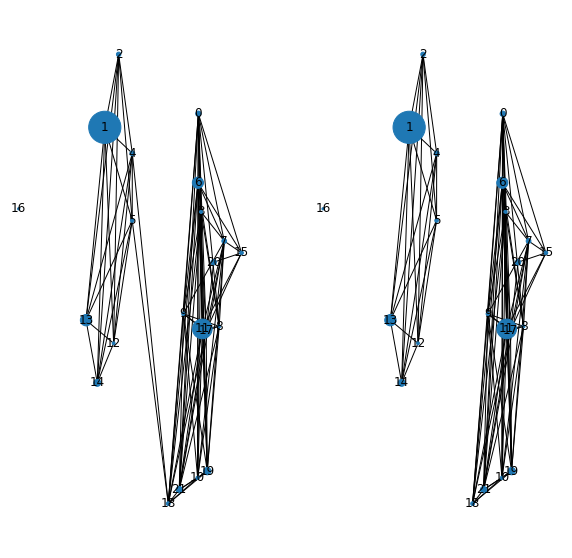

In [41]:
G = torch_geometric.utils.to_networkx(X, to_undirected=True)
newData = Data(x=X.x, num_nodes=X.num_nodes, edge_index=X.edge_index[:, X.y > 0])
newG = torch_geometric.utils.to_networkx(newData, to_undirected=True)

pos = dict(zip(list(range(X.num_nodes)), X.x[:, :2]))

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
nx.draw(G, with_labels=True, ax=ax[0], pos=pos, node_size=X.x[:, 16]*5)
nx.draw(newG, with_labels=True, ax=ax[1], pos=pos, node_size=X.x[:, 16]*5)

Cycle trough a full sequence creation by hand:

In [42]:
roots = X.roots[np.argsort(-X.x[X.roots, 16])]
roots

tensor([ 0,  2, 16])

In [43]:
root = roots[0].item()

In [44]:
root_subgraph = np.array(build_subgraph(X.edge_index, root, 1), dtype=int)
root_subgraph = root_subgraph[np.argsort(-X.x[root_subgraph, 16])]
root_subgraph

array([11,  6, 19, 21, 20,  0,  4,  7, 17, 18, 15,  5,  9, 10,  3,  8])

In [45]:
sorted_graph = np.array(np.argsort(-X.x[:, 16]), dtype=int)
sorted_graph

array([ 1, 11, 13,  6, 19, 14, 21, 20,  0,  4,  7,  2, 17, 18, 15,  5,  9,
       10,  3,  8, 12, 16])

In [46]:
if (root_subgraph.shape[0] > 1):
    root_group = sorted_graph[X.cluster[sorted_graph] == X.cluster[root].item()]
else:
    root_group = sorted_graph
root_group

array([11,  6, 19, 21, 20,  0,  7, 17, 18, 15,  9, 10,  3,  8])

In [47]:
sample_seq = converter.y2seq(root, sorted_graph, np.array(X.cluster))
sample_seq

array([ 1, 15, 10, 23, 25, 24,  4, 11, 21, 22, 19, 13, 14,  7, 12,  3,  5,
       17, 18,  8,  6,  9, 16, 20,  3,  2,  0])

In [48]:
i = -1
visited = []

In [49]:
i = sample_seq.shape[0]-3
seq = converter.subseq(sample_seq, seq_length=input_length, index=i-input_length+2)
seq

array([ 4, 11, 21, 22, 19, 13, 14,  7, 12,  3,  5, 17, 18,  8,  6,  9, 16,
       20,  3,  2])

In [50]:
seq[-1]

2

In [51]:
subgraph = np.array([])
if (seq[-1] > converter.word2index[";"]):
    new_root = int(converter.index2word[seq[-1]])
    subgraph = np.array(build_subgraph(X.edge_index, new_root, 2), dtype=int)
    subgraph = np.array(subgraph, dtype=int)
    
    subgraph = np.setdiff1d(subgraph, np.array(visited))
    visited.append(seq[-1])
subgraph

array([], dtype=float64)

In [52]:
np.array(visited)

array([], dtype=float64)

In [53]:
if (subgraph.shape[0] > 1):
    group = subgraph[X.cluster[subgraph] == X.cluster[new_root].item()]
    group = np.setdiff1d(group, visited)
    
    if (group.shape[0] == 0):
        group = sample_seq[i+2]
elif(subgraph.shape[0] == 1):
    group = subgraph
else:
    group = sample_seq[i+2]

## Graph Components

In [54]:
from ClusterDataset import ClusterDataset
from graph_utils import find_connected_components
import plotly.graph_objects as go

import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [55]:
data_folder_training = "/eos/user/c/czeh/graph_data"
hist_folder = "/eos/user/c/czeh/histo/"
dataset_training = ClusterDataset(data_folder_training, hist_folder)

In [65]:
data_idx = 35
X = dataset_training.get(data_idx)

In [76]:
edges = []
nodes = []
roots = []

components = find_connected_components(X.edge_index, X.x.shape[0])

for component in components:
    component = np.array(component, dtype=int)
    
    root = torch.argmax(X.x[component, 16]).item()
    root_cluster = X.cluster[root].item()
    sample_seq = converter.y2seq(root, component, np.array(X.cluster))    
    seq = np.array(list(map(converter.index2word.get, sample_seq)))[1:-2]

    node = []
    print(seq)
    roots.append(int(seq[0]))
    for i in range(seq.shape[0]):
        if(seq[i] == ";"):
            nodes.append(node)
            node = []
        else:
            node.append(int(seq[i]))
        
        if (seq[i] != ";" and seq[i + 1] != ";"):
            edges.append([int(seq[i]), int(seq[i+1])])
edges = np.array(edges)

['12' '6' '7' '15' '20' '2' '3' '4' '18' '23' '26' '30' '5' '14' '21' ';'
 '0' '1' '9' '10' '11' '13' '16' '17' '19' '22' '24' '25' '27' '28' '29'
 '31' ';']


In [77]:
roots

[12]

In [70]:
# Create plot
fig = go.Figure()

# Extract edge coordinates
edge_x, edge_y, edge_z = [], [], []
for u, v in edges:
    x0, y0, z0 = X.x[u, :3]
    x1, y1, z1 = X.x[v, :3]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_z += [z0, z1, None]


# Add edges
fig.add_trace(go.Scatter3d(
    x=edge_x, y=edge_y, z=edge_z,
    mode='lines',
    line=dict(color='gray', width=2),
    hoverinfo='none'
))

color = ["red", "blue", "orange"]
# Node coordinates
for c in torch.unique(X.cluster):
    node_x = [node[0].item() for node in X.x[X.cluster == c.item()]]
    node_y = [node[1].item() for node in X.x[X.cluster == c.item()]]
    node_z = [node[2].item() for node in X.x[X.cluster == c.item()]]
    node_size = [node[16].item()/2 for node in X.x[X.cluster == c.item()]]
    name = np.array(range(X.x.shape[0]))[X.cluster == c.item()]
    
    fig.add_trace(go.Scatter3d(
        x=node_x, y=node_y, z=node_z,
        mode='markers',
        marker=dict(size=node_size, color=color[c.item()]),
        hoverinfo='text',
        text=[str(i) for i in range(X.x.shape[0])]
    ))

fig.update_layout(
    title=f'Sequence Line of two Trackster Group; Event: {data_idx}',
    showlegend=False,
    scene=dict(
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False),
        zaxis=dict(showgrid=False)
    )
)

fig.show()

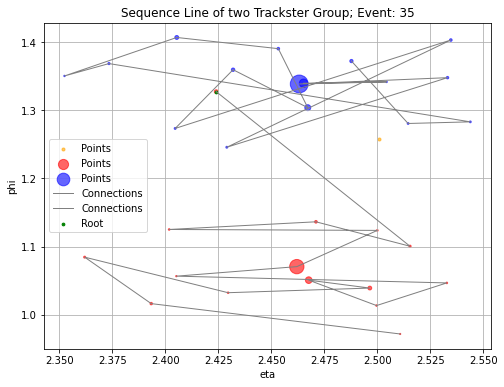

In [74]:
# Example data
x = edges.T[0]
y = edges.T[1]
sizes = [100, 200, 300, 400, 500]  # size for each point

# Create the plot
plt.figure(figsize=(8, 6))
color = ["red", "blue", "orange"]

for c in torch.unique(X.cluster):
    node_x = [node[3].item() for node in X.x[X.cluster == c.item()]]
    node_y = [node[4].item() for node in X.x[X.cluster == c.item()]]
    node_size = [node[16].item()*2 for node in X.x[X.cluster == c.item()]]
    name = np.array(range(X.x.shape[0]))[X.cluster == c.item()]
    plt.scatter(node_x, node_y, s=node_size, c=color[c.item()], alpha=0.6, label='Points')

for node in nodes:
    # Connect points with lines
    endpoints = X.x[node]
    plt.plot(endpoints[:, 3], endpoints[:, 4], color='gray', linestyle='-', linewidth=1, label='Connections')
    
root_points = X.x[roots]
plt.scatter(root_points[:, 3], root_points[:, 4], s=root_points[:, 16], color='green', label='Root')


# Labels and legend
plt.xlabel('eta')
plt.ylabel('phi')
plt.title(f'Sequence Line of two Trackster Group; Event: {data_idx}')
plt.legend()
plt.grid(True)
plt.show()